In [29]:
# To make sure to be in the right Python virtual environment
import sys
print(sys.executable)

/home/user/datacraft/rust_for_data_science/.venv/bin/python


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import time

## Dataset definition and visualization

In [31]:
n_blobs = 5
n_clusters = 5
X, y = make_blobs(n_samples=1000, centers=n_blobs, cluster_std=0.8)#, random_state=0)

labels, counts = np.unique(y, return_counts=True)

print(X.shape)
print(X[: 10])
print(y)

(1000, 2)
[[ -1.32950176  -9.67372188]
 [  5.42386603  -2.06148431]
 [ -3.45545193  -8.81644452]
 [  0.71635605   4.77601428]
 [ -2.74853192  -8.41513146]
 [  1.94319866   6.83864742]
 [ -2.46386115 -10.29193187]
 [  3.41561488   1.96933752]
 [ -3.61170225  -9.11932237]
 [  5.2921766    0.79909566]]
[0 3 0 1 2 1 0 4 0 4 2 3 1 0 3 0 1 0 0 3 2 1 0 4 1 1 1 3 3 2 3 2 0 4 3 2 4
 1 0 2 2 2 4 2 0 0 2 4 3 3 1 2 1 0 2 4 4 0 2 3 3 3 4 4 0 3 2 2 0 3 4 3 4 4
 4 4 3 2 3 3 0 4 0 4 3 0 3 3 0 2 0 1 4 1 1 3 1 1 1 4 2 3 4 4 4 0 0 0 2 4 1
 0 4 2 1 1 1 3 3 1 2 0 4 3 3 1 0 2 1 1 4 0 4 2 2 1 3 0 0 4 0 3 4 3 4 2 0 1
 2 1 4 2 1 1 2 1 1 1 4 3 4 2 1 1 0 3 0 0 1 3 2 2 3 2 4 2 2 0 1 3 3 3 1 1 3
 4 2 4 3 1 1 1 0 4 3 1 1 3 3 0 0 0 1 2 3 0 1 1 4 1 1 4 4 1 4 1 1 4 2 4 1 0
 2 3 3 0 0 2 0 2 2 2 0 3 1 2 4 1 4 4 0 0 4 1 2 1 3 0 3 2 1 2 0 0 1 4 4 0 1
 3 2 3 2 0 3 1 1 1 3 4 1 2 1 0 3 3 2 1 0 0 3 2 4 2 3 2 0 1 2 3 3 2 4 4 4 3
 4 1 4 4 4 0 2 4 3 3 0 1 3 1 2 2 0 3 4 2 3 0 3 2 3 0 4 2 3 2 4 2 2 0 4 2 2
 4 3 0 0 1 4 2 4 0 1 1 3

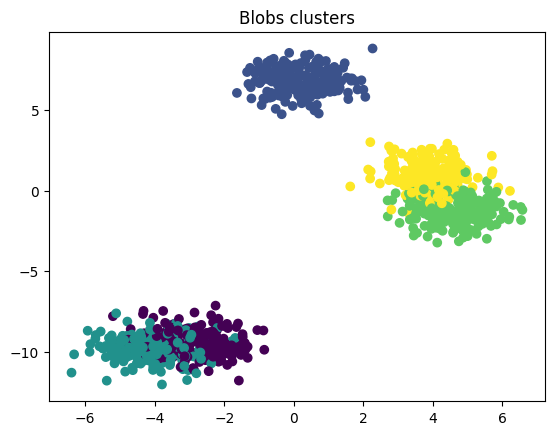

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Blobs clusters")
plt.show()

In [33]:
true_centroids = np.array([np.zeros(len(X[0])) for _ in range(n_clusters)])
for i in range(len(X)):
    true_centroids[y[i]] += X[i]
for k in range(n_clusters):
    true_centroids[k] /= counts[k]

print(true_centroids)

[[-2.80756933 -9.42130676]
 [ 0.18492996  6.79441495]
 [-4.2085969  -9.75958568]
 [ 4.61760483 -1.28730414]
 [ 3.87398272  1.00227052]]


## Kmeans implementation

In [34]:
def dist(x1, x2):
    s = 0
    for i in range(len(x1)):
        s += (x1[i] - x2[i])**2
    return np.sqrt(s)

def dist_(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def init_kmeans_pp(X, n_clusters):
    X = np.array(X)
    n_samples, _ = X.shape

    # Chooses first centroid randomly
    centroids = [X[random.randrange(n_samples)]]

    for _ in range(1, n_clusters):
        # Computes distances to the nearest centroid
        distances = np.array([min(np.sum((x - c)**2) for c in centroids) for x in X])

        # Defines proportionnal probabilities according to distances
        probabilities = distances / distances.sum()

        # Computes a new centroid
        cumulative_prob = np.cumsum(probabilities)
        r = random.random()
        for i, p in enumerate(cumulative_prob):
            if r < p:
                centroids.append(X[i])
                break

    return np.array(centroids)

In [35]:
def kmeans_alamano(X, n_clusters, max_iter=300, tol=1e-6, init=None, debug=False):
    
    # Constants of the dataset
    n_samples, n_features = X.shape

    # Initializes centroids
    if init == "kmean++":
        centroids = init_kmeans_pp(X, n_clusters)
    else:
        # Random initialization of centroids
        centroids = np.array([X[random.randrange(n_samples)] for _ in range(n_clusters)])
    prev_centroids = np.array([np.zeros(n_features) for _ in range(n_clusters)])

    # Iterations of Kmeans
    for iteration in range(max_iter):
    
        # Computes clusters according to the centroids
        clusters = [[] for _ in range(n_clusters)]
        for x_i in X:
            to_k = 0
            dist_min = np.inf
            for k in range(n_clusters):
                dist_to_k = dist(x_i, centroids[k])

                if debug :
                    print("dist_to_k < dist_min?", dist_to_k, dist_min, dist_to_k < dist_min)
                
                if dist_to_k < dist_min:
                    to_k = k
                    dist_min = dist_to_k
                
                    if debug :
                        print(dist_min)
            
            if debug :
                print(to_k)
            
            clusters[to_k].append(x_i)

        # Computes centroids
        for k in range(n_clusters):
            centroids_k = np.zeros(n_features)
            for x_ik in clusters[k]:
                centroids_k += x_ik
            centroids[k] = centroids_k/(len(clusters[k]) if len(clusters[k])>1 else 1)
            
        # Checks the convergence
        dist_centroids = 0
        for c_k, pc_k in zip(centroids, prev_centroids):
            dist_centroids += dist(c_k, pc_k)
        if dist_centroids < tol:

            if debug :
                print(iteration)
            
            break

        # Keeps previous centroids in memory
        prev_centroids = centroids.copy()
        # print(centroids)

    return centroids, clusters

## Tests

In [36]:
n_clusters = 5

#### Python with sklearn

Python sklearn time : 0.015942811965942383
Python sklearn result : [[  4.24579377  -0.14251681]
 [ -2.3777644   -9.27063405]
 [  0.18492996   6.79441495]
 [ -4.51179755  -9.33300979]
 [ -3.60019509 -10.3684906 ]]


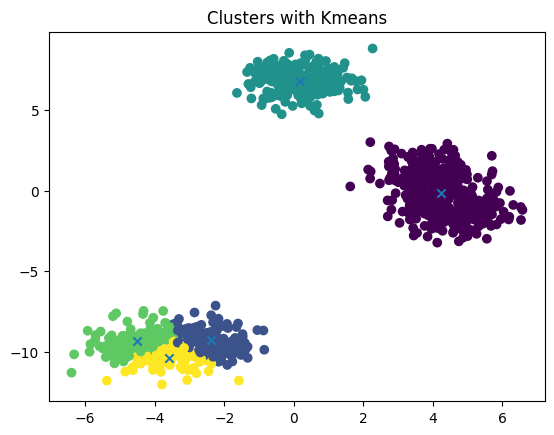

In [37]:
# Kmeans Python from sklearn
start = time.time()
kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
model = kmeans.fit(X)
clusters_py_sk = model.predict(X)
centroids_py_sk = model.cluster_centers_
print("Python sklearn time :", time.time() - start)
print("Python sklearn result :", centroids_py_sk)

# Plot clusters computed with Kmeans algorithm
plt.scatter(X[:, 0], X[:, 1], c=clusters_py_sk)
plt.scatter(centroids_py_sk[:, 0], centroids_py_sk[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

#### Python manual implementation

Python scratch time : 0.13500070571899414
Python scratch result : [[ 0.27409739  7.45161053]
 [-4.33383478 -9.64469739]
 [ 0.10425467  6.19980942]
 [ 4.24579377 -0.14251681]
 [-2.50896922 -9.52480531]]


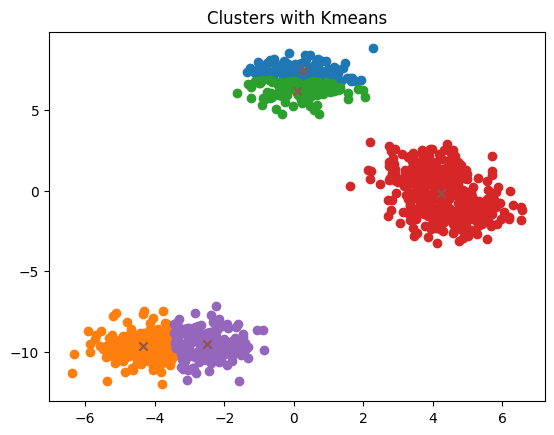

In [38]:
# Kmeans Python from scratch
start = time.time()
centroids_py_scratch, clusters_py_scratch = kmeans_alamano(X, n_clusters, init="kmeans++")
print("Python scratch time :", time.time() - start)
print("Python scratch result :", centroids_py_scratch)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_py_scratch:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_py_scratch[:, 0], centroids_py_scratch[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

#### Rust with manual implementation

In [39]:
import rust_pyo3

Rust scratch time : 0.051180124282836914
Rust scratch result : [[ 3.83457953  1.01050555]
 [ 0.18492996  6.79441495]
 [-2.50896922 -9.52480531]
 [-4.33383478 -9.64469739]
 [ 4.67809593 -1.35466853]]


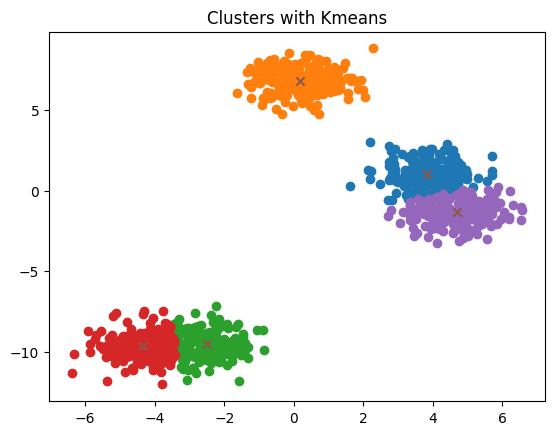

In [40]:
# Kmeans Rust from scratch
start = time.time()
centroids_rust, clusters_rust = rust_pyo3.kmeans_alamano(X, n_clusters, init="kmeans++")
print("Rust scratch time :", time.time() - start)
print("Rust scratch result :", centroids_rust)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_rust:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_rust[:, 0], centroids_rust[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

### Rust with linfa_clustering

Rust scratch time : 0.6516053676605225
Rust scratch result : [[ 3.83457953  1.01050555]
 [ 0.18492996  6.79441495]
 [-2.50896922 -9.52480531]
 [-4.33383478 -9.64469739]
 [ 4.67809593 -1.35466853]]


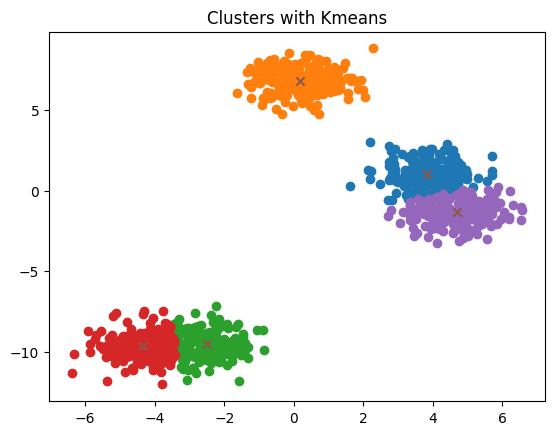

In [41]:
# Kmeans Rust from linfa_clustering
start = time.time()
centroids_rust_linfa = rust_pyo3.linfa_kmeans_test(X, n_clusters, max_iter=300, tol=1e-6)

clusters_rust = [[] for _ in range(n_clusters)]
for x_i in X:
    to_k = 0
    dist_min = np.inf
    for k in range(n_clusters):
        dist_to_k = dist(x_i, centroids_rust[k])
        if dist_to_k < dist_min:
            to_k = k
            dist_min = dist_to_k
    clusters_rust[to_k].append(x_i)
print("Rust scratch time :", time.time() - start)
print("Rust scratch result :", centroids_rust)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_rust:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_rust[:, 0], centroids_rust[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

## Mean time

In [42]:
N = 1000

In [ ]:
py_sk_time = []
py_time = []
rust_time = []

for _ in range(N):
    start = time.time()
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
    model = kmeans.fit(X)
    clusters_py_sk = model.predict(X)
    centroids_py_sk = model.cluster_centers_
    py_sk_time.append(time.time() - start)

    start = time.time()
    centroids_py_scratch, clusters_py_scratch = kmeans_alamano(X, n_clusters, init="kmeans++")
    py_time.append(time.time() - start)

    start = time.time()
    centroids_rust, clusters_rust = rust_pyo3.kmeans_alamano(X, n_clusters, init="kmeans++")
    rust_time.append(time.time() - start)

E_py_sk = np.mean(py_sk_time)
E_py = np.mean(py_time)
E_rust = np.mean(rust_time)

print("Mean time execution Python with sklearn :", E_py_sk)
print("Mean time execution Python with manual implementation :", E_py)
print("Mean time execution Rust with manual implementation :", E_rust)


Mean time execution Python with sklearn : 0.00456937837600708
Mean time execution Python with manual implementation : 0.1339815185070038
Mean time execution Rust with manual implementation : 0.05180537605285645
